## Import Library

In [1]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import numpy as np
import torchvision.transforms as tt
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

## Load Model And Set Model To Gpu If Available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load(r'/home/kusan/bird/finalmodel/scripted_bird_classification_model (halka-small).pt')  # Load your model
model.to(device)

/home/kusan/anaconda3/envs/project1/lib/python3.9/site-packages/torch/serialization.py:1006: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=BirdClassificationModel
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(
      original_name=SEBlock
      (fc1): RecursiveScriptModule(original_name=Linear)
      (fc2): RecursiveScriptModule(original_name=Linear)
    )
    (4): RecursiveScriptModule(original_name=MaxPool2d)
    (5): RecursiveScriptModule(original_name=Conv2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=BatchNorm2d)
    (8): RecursiveScriptModule(original_name=ReLU)
    (9): RecursiveScriptModule(
      original_name=SEBlock
      (fc1): RecursiveScriptModule(original_name=Linear)
      (fc2): RecursiveScriptModule(original_name=Linear)
    )
    (10): RecursiveScriptModule(original_name=MaxPool2d)
    (11): RecursiveSc

## Count Total Parameter

In [3]:
#print total trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,579,801 trainable parameters


## Load Test Set

In [4]:
test_imgs = '/home/kusan/bird/seendataset(416)/bird dataset/val'

## Transform Image To Meet Model Requirement

In [5]:
image_size = (416,416)
mean =  [0.49139968, 0.48215841, 0.44653091]
std = [0.24703223, 0.24348513, 0.26158784]

In [6]:
transformations_to_perform = transform=tt.Compose([
                                tt.Resize(image_size),
                                tt.ToTensor(),
                                tt.Normalize(mean, std)])
test_dataset = ImageFolder(test_imgs, transformations_to_perform)

## Make Prediction On Each Image

In [7]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
def prediction(test_loader, model, device):
    model.eval()
    list_of_prediction = []
    labels = []
    
    with torch.no_grad():
        # Wrap the test_loader with tqdm for progress indication
        for imgs, label in tqdm(test_loader, desc="Processing", leave=False):
            imgs, label = imgs.to(device), label.to(device)  # Move data to the appropriate device

            output = model(imgs)
            if isinstance(output, tuple):  # Check if output is a tuple
                output = output[0]  # Assuming the first element is the tensor we need

            list_of_prediction.extend(output.argmax(dim=1).cpu().numpy())  # Get the index of the max log-probability
            labels.extend(label.cpu().numpy())  # Assuming label is already in the correct format

    return np.array(list_of_prediction), np.array(labels)

In [9]:
predictions, test_labels = prediction(test_loader, model, device)

## Evaluate Metrices based on Confusion Matrix Data

In [10]:
class_names = test_dataset.classes  # List of class names

                           precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.98      0.96      0.97       300
      Brown-Headed-Barbet       0.93      0.93      0.93       300
             Cattle-Egret       0.98      0.97      0.97       300
        Common-Kingfisher       0.99      0.95      0.97       300
              Common-Myna       0.99      0.96      0.97       300
         Common-Rosefinch       0.94      0.91      0.93       300
        Common-Tailorbird       0.96      0.91      0.93       300
       Coppersmith-Barbet       0.95      0.98      0.96       300
           Forest-Wagtail       0.94      0.94      0.94       300
             Gray-Wagtail       0.94      0.97      0.96       300
                   Hoopoe       0.98      0.95      0.97       300
               House-Crow       0.90      0.93      0.92       300
     Indian-Grey-Hornbill       0.86      0.87      0.86       300
           Indian-Peacock       0.94      0.97      0.95     

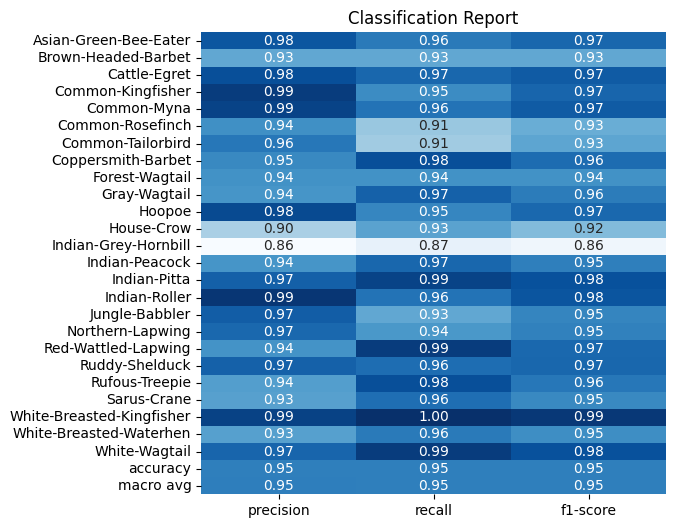

: 

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
class_names = test_dataset.classes  # List of class names
# Generate the classification report as a dictionary
report_dict = classification_report(test_labels, predictions, target_names=class_names, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# Plot the DataFrame as a heatmap
plt.figure(figsize=(6,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt=".2f", cbar=False)
plt.title('Classification Report')
plt.yticks(rotation=0)  # Rotate y-axis labels to horizontal
plt.xticks(rotation=0)  # Rotate x-axis labels slightly
plt.show()


In [11]:
conf_matrix = confusion_matrix(test_labels, predictions)

## Visualize Confusion Matrix

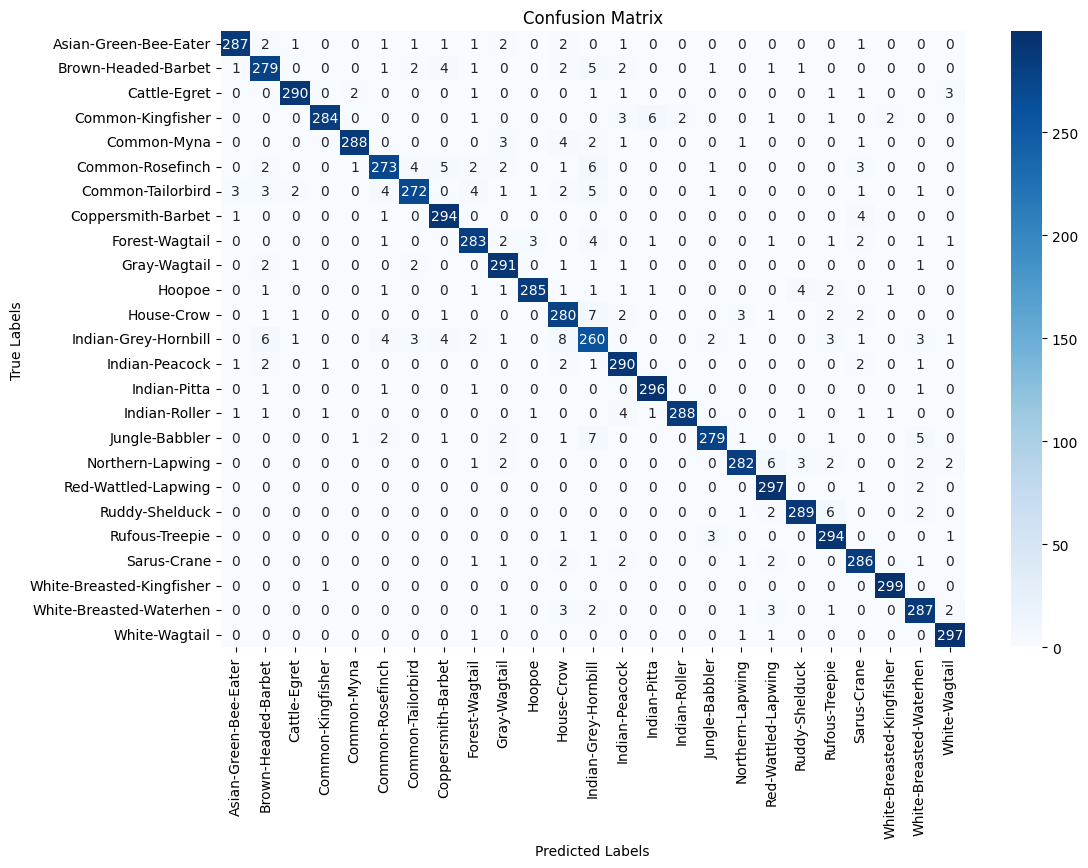

In [12]:
import seaborn as sns
def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to plot the confusion matrix
plot_confusion_matrix(conf_matrix, class_names)

## ROC Curve And Area Under Curve

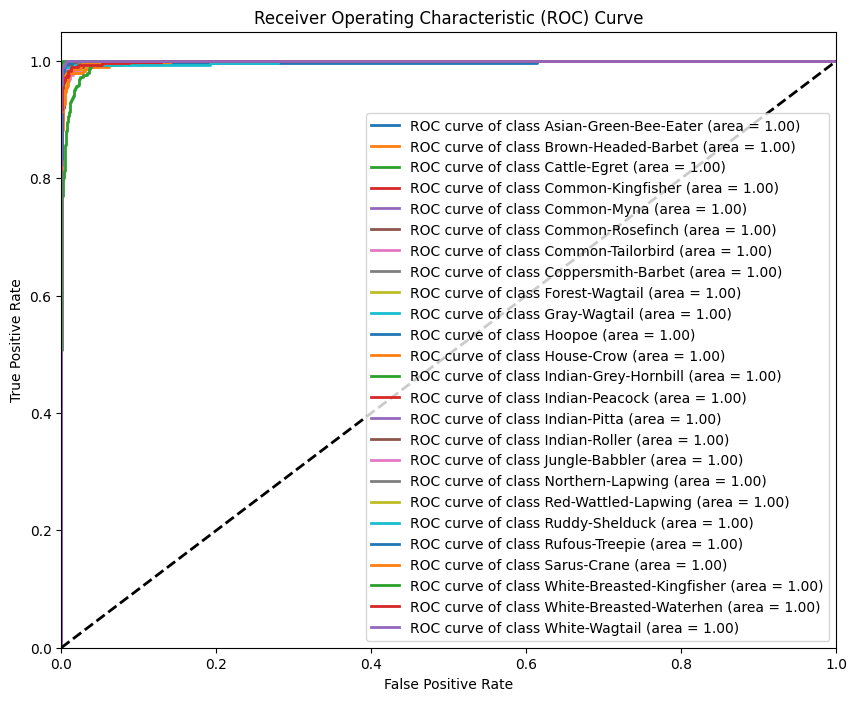

In [13]:
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Function to get prediction probabilities
def prediction_with_probabilities(test_loader, model, device):
    model.eval()  # Set the model to evaluation mode
    probabilities = []
    true_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)  # Ensure outputs is a tensor or tuple

            # Check if outputs is a tuple, and extract logits
            if isinstance(outputs, tuple):
                logits = outputs[0]  # Adjust index based on your model
            else:
                logits = outputs

            # Apply softmax to get probabilities
            probs = torch.nn.functional.softmax(logits, dim=1)
            probabilities.append(probs.cpu().numpy())
            true_labels.append(labels.cpu().numpy())
    
    probabilities = np.concatenate(probabilities)
    true_labels = np.concatenate(true_labels)
    return probabilities, true_labels

# Get probabilities and true labels
probs, true_labels = prediction_with_probabilities(test_loader, model, device)
class_names = test_dataset.classes
n_classes = len(class_names)

# Binarize the test labels
true_labels_binarized = label_binarize(true_labels, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
